# Testing K-means Clustering
### Use techniques we've already learned in class to try and make progress on identifying roads

Imports

In [2]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skimor
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

### Read data file and show images

In [3]:
image_filepath = "../data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels

In [18]:
image = skio.imread(image_filepath + "/train/10078675_15.tiff")
image_label = skio.imread(image_filepath + "/train_labels/10078675_15.tif")

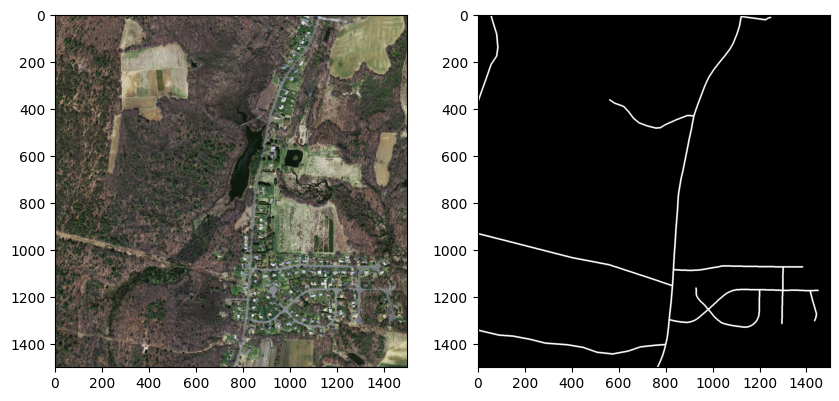

In [19]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(image)
axes[1].imshow(image_label, cmap='gray')

plt.show()

Cropping Image for testing

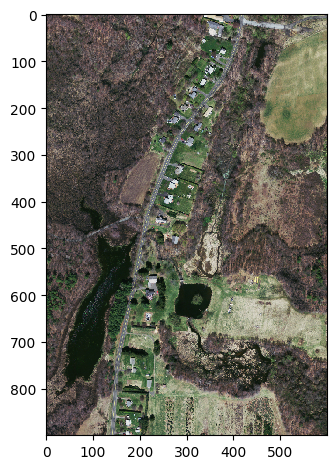

In [20]:
x1, y1 = 700, 0
x2, y2 = 1300, 900
image = image[y1:y2, x1:x2, :]
skio.imshow(image)

### Function for calculating label accuracy

In [21]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred)

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # True positive rate
    tpr = (C[0,0])/(C[0,0] + C[0,1])
    
    # True negative rate
    tnr = (C[1,1])/(C[1,0] + C[1,1])

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nTrue positive rate (not road):", np.round(tpr, 3),
            "\nTrue negative rate (roads)", np.round(tnr, 3)) 

In [22]:
#what values are used in label image
np.unique(image_label)

array([  0, 255], dtype=uint8)

### Reshape image

In [23]:
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

### K means clustering from OpenCV
https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/

In [24]:
#the below line of code defines the criteria for the algorithm to stop running, 
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy) 
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering with number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

In [25]:
np.unique(segmented_image)

array([ 44,  48,  52,  81,  93,  97, 131, 154, 158], dtype=uint8)

That's weird, I chose 2 clusters but we have more than two values in the segmented image, maybe this is just for visualization?

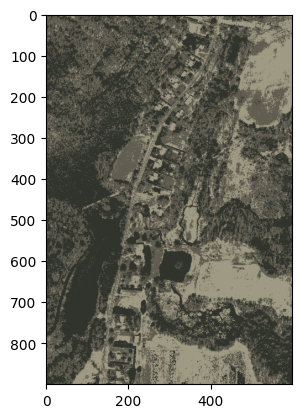

In [26]:
plt.imshow(segmented_image)

### K means from sklearn

In [27]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(pixel_vals)

Initialization complete
Iteration 0, inertia 1476542848.0.
Iteration 1, inertia 594391808.0.
Iteration 2, inertia 563052416.0.
Iteration 3, inertia 558555072.0.
Iteration 4, inertia 557961408.0.
Iteration 5, inertia 557888448.0.
Converged at iteration 5: center shift 0.049239665269851685 within tolerance 0.17208853759765627.


In [28]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

In [29]:
skio.imshow(sk_segmented_image, cmap='gray')

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


### Let's try to input a few more things into the model

Let's try to put a horizontal and vertically run edge detection using Sobel kernels

In [30]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

# Perform convolutions
edges_horizontal = convolve2d(image_gray, sobel_horizontal, mode='same', boundary='symm')
edges_vertical = convolve2d(image_gray, sobel_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

In [31]:
skio.imshow(edges, cmap='gray')

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Let's see if canny edge detection works better

In [32]:
# Calculation Canny gradient
canny_edges = feature.canny(image_gray, sigma=3)

### Dilation to create crisper edges

In [47]:
# Create disk
disk = skimor.disk(1)

# Area closing
closed_edges = skimor.dilation(canny_edges, footprint = disk)
closed_edges = closed_edges * 255

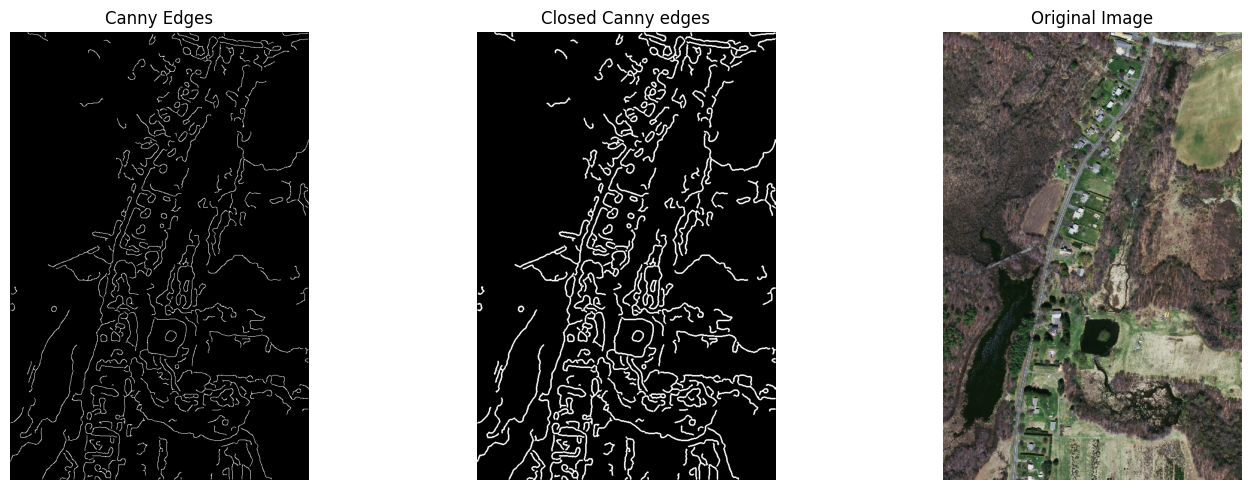

In [48]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(canny_edges, cmap='gray')
ax[0].set_title('Canny Edges')

ax[1].imshow(closed_edges, cmap='gray')
ax[1].set_title('Closed Canny edges')

ax[2].imshow(image)
ax[2].set_title('Original Image')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Now lets add this new channel to the image and see what happens

In [49]:
image_with_canny = np.dstack((image, closed_edges.astype(np.uint8) * 255))

In [50]:
feature_vals = image_with_canny.reshape((-1,4))
feature_vals = np.float32(feature_vals)

In [55]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(feature_vals)

Initialization complete
Iteration 0, inertia 790624064.0.
Iteration 1, inertia 594012608.0.
Iteration 2, inertia 583596160.0.
Iteration 3, inertia 576549312.0.
Iteration 4, inertia 571544768.0.
Iteration 5, inertia 567993664.0.
Iteration 6, inertia 565385984.0.
Iteration 7, inertia 563468224.0.
Iteration 8, inertia 562068352.0.
Iteration 9, inertia 561027456.0.
Iteration 10, inertia 560268672.0.
Iteration 11, inertia 559695680.0.
Iteration 12, inertia 559248768.0.
Iteration 13, inertia 558906112.0.
Iteration 14, inertia 558644416.0.
Iteration 15, inertia 558446144.0.
Iteration 16, inertia 558306560.0.
Iteration 17, inertia 558198912.0.
Iteration 18, inertia 558121984.0.
Iteration 19, inertia 558067264.0.
Converged at iteration 19: center shift 0.10784302651882172 within tolerance 0.1290685546875.


In [56]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


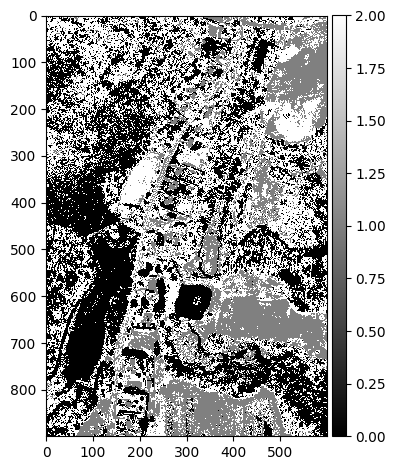

In [57]:
skio.imshow(sk_segmented_image, cmap='gray')

In [60]:
np.unique(sk_segmented_image)

array([0, 1, 2], dtype=int32)

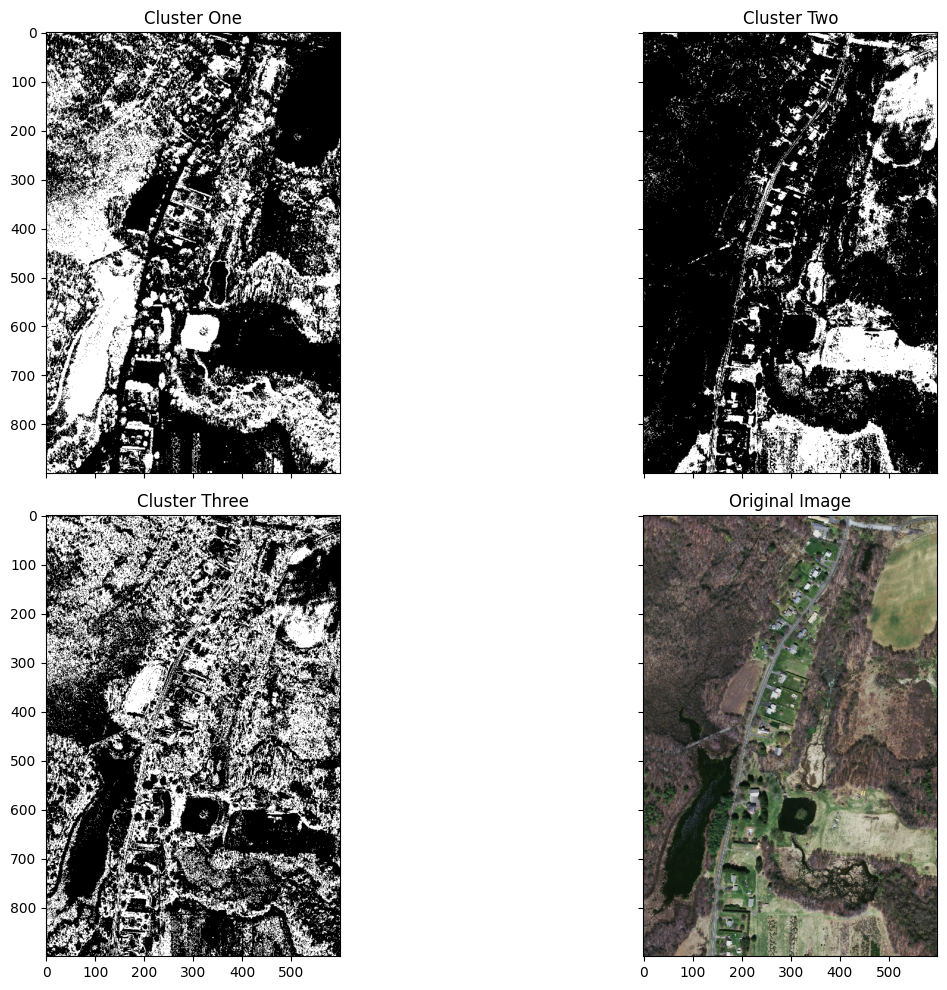

In [63]:
# Generating figure 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

cluster_one = (sk_segmented_image==0)
axes[0][0].imshow(cluster_one, cmap='gray')
axes[0][0].set_title('Cluster One')

cluster_two = (sk_segmented_image==1)
axes[0][1].imshow(cluster_two, cmap='gray')
axes[0][1].set_title('Cluster Two')

cluster_three = (sk_segmented_image==2)
axes[1][0].imshow(cluster_three, cmap='gray')
axes[1][0].set_title('Cluster Three')

axes[1][1].imshow(image)
axes[1][1].set_title('Original Image')


plt.tight_layout()
plt.show()

### Hough Transform for detecting straight edges

In [64]:
lines = transform.probabilistic_hough_line(closed_edges, threshold=20, line_length=20, line_gap=3)

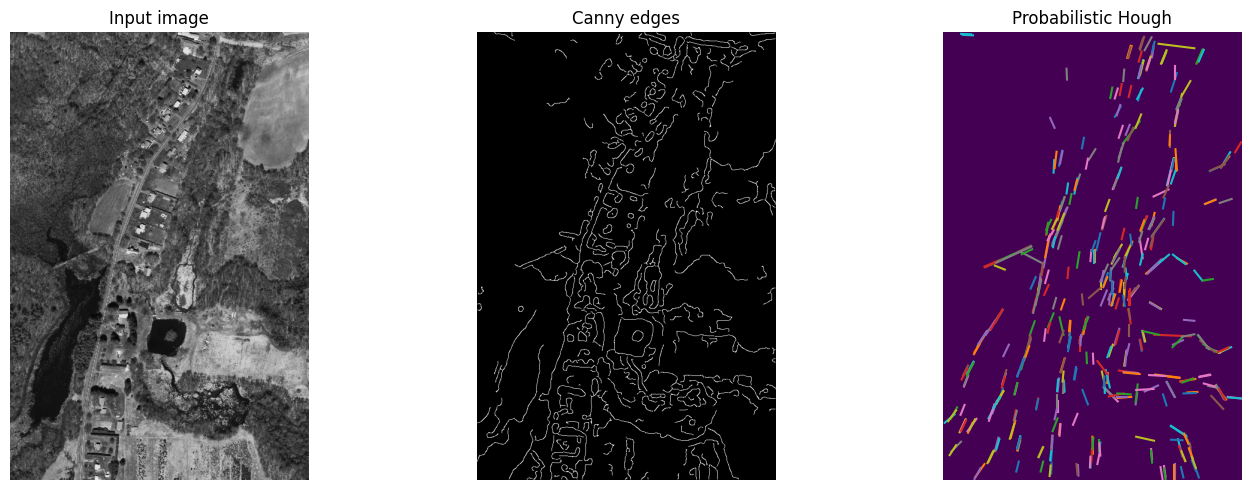

In [65]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(canny_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image_gray.shape[1]))
ax[2].set_ylim((image_gray.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Let's try to classify gray pixels, these may help identify the roads

In [127]:
def classify_gray(image):

    # Convert the image to Lab color space
    lab_image = skol.rgb2lab(image)

    # Compute the standard deviation of the a and b channels
    ab_diff = np.abs(lab_image[:,:,1] - lab_image[:,:,2])

    intensity_low = 40
    intensity_high = 60
    mid_intensties = lab_image[:,:,0]>intensity_low
    mid_intensties = mid_intensties<intensity_high

    # Define a threshold for classifying gray pixels
    diff_threshold = 3  # Adjust as needed
    close_ab = ab_diff < diff_threshold

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = np.logical_and(close_ab, mid_intensties)
        
    return gray_mask

In [128]:
gray_mask = classify_gray(image)
gray_mask = gray_mask.reshape((image.shape[0], image.shape[1]))

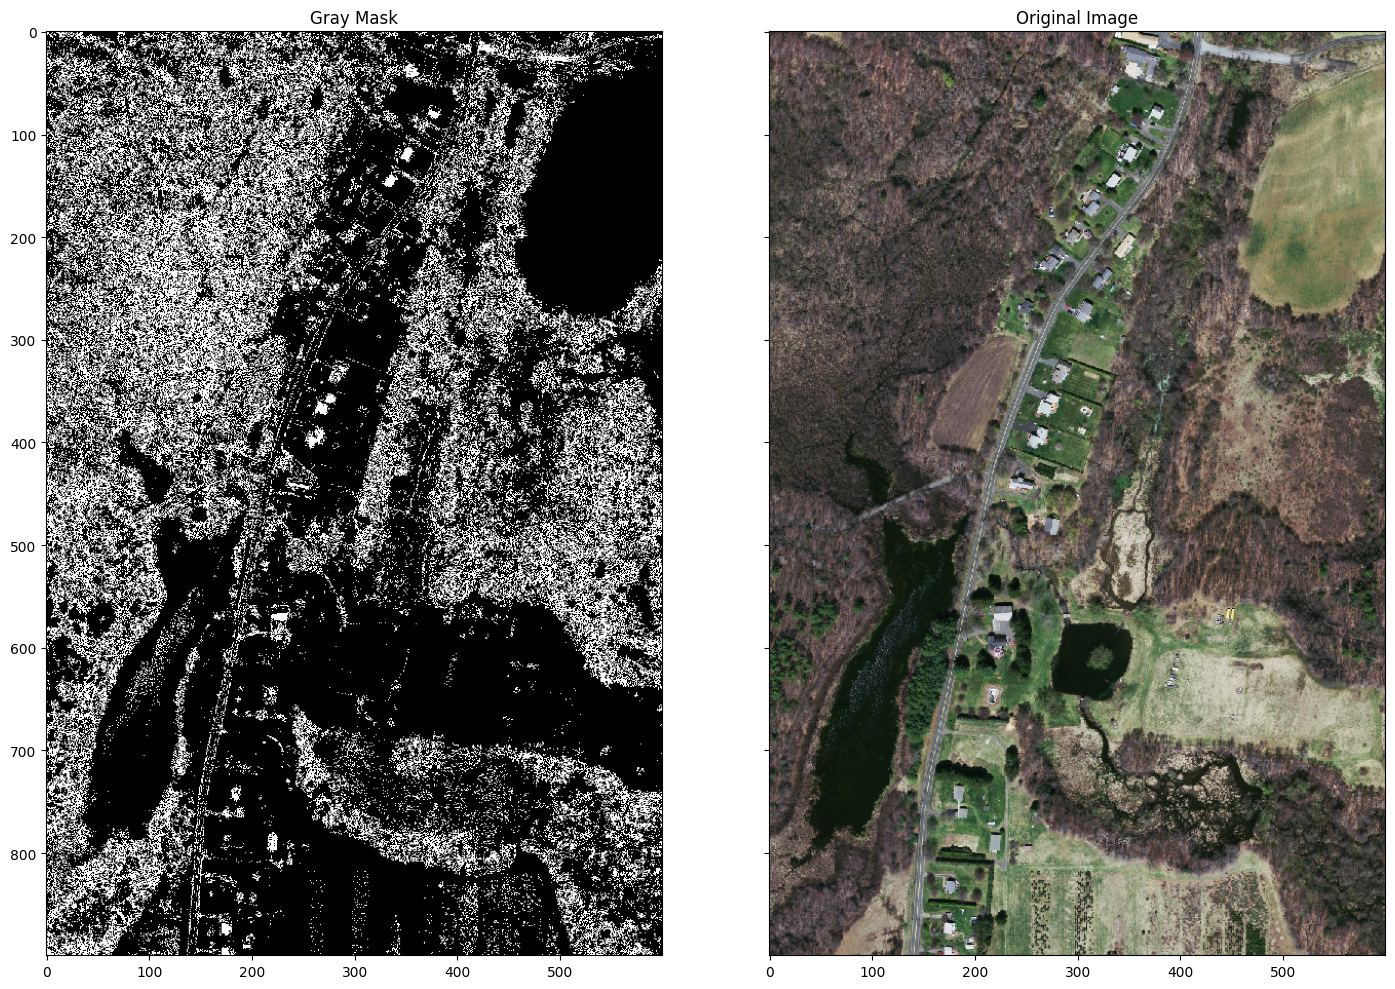

In [129]:
# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].imshow(gray_mask, cmap='gray')
axes[0].set_title('Gray Mask')

axes[1].imshow(image)
axes[1].set_title('Original Image')

plt.tight_layout()
plt.show()